<a href="https://colab.research.google.com/github/redman157/HocML/blob/master/colaborative-filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pson2809","key":"f045f4a4adb9707f5c86d18bc28608b2"}'}

In [0]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar  7 22:45 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# List available datasets.
!kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
ronitf/heart-disease-uci                                     Heart Disease UCI                                     3KB  2018-06-25 11:33:56          13487  
russellyates88/suicide-rates-overview-1985-to-2016           Suicide Rates Overview 1985 to 2016                 396KB  2018-12-01 19:18:25           9630  
lava18/google-play-store-apps                                Google Play Store Apps                                2MB  2019-02-03 13:55:47          40337  
iarunava/cell-images-for-detecting-malaria                   Malaria Cell Images Dataset                         337MB  2018-12-05 05:40:21           2352  
mohansacharya/graduate-admissions                         

In [5]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!kaggle datasets download -d tmdb/tmdb-movie-metadata

 98% 224M/228M [00:03<00:00, 91.2MB/s]
100% 228M/228M [00:03<00:00, 77.3MB/s]
 54% 5.00M/9.30M [00:00<00:00, 36.6MB/s]
100% 9.30M/9.30M [00:00<00:00, 42.8MB/s]


In [6]:
!unzip the-movies-dataset.zip

Archive:  the-movies-dataset.zip
  inflating: ratings.csv             
  inflating: ratings_small.csv       
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: keywords.csv            
  inflating: movies_metadata.csv     
  inflating: credits.csv             


In [7]:
!unzip tmdb-movie-metadata.zip

Archive:  tmdb-movie-metadata.zip
  inflating: tmdb_5000_credits.csv   
  inflating: tmdb_5000_movies.csv    


In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import StandardScaler

df1 = pd.read_csv('tmdb_5000_credits.csv')
df2 = pd.read_csv('tmdb_5000_movies.csv')

In [9]:
!sudo pip install scikit-surprise

    100% |████████████████████████████████| 3.3MB 8.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
def load_tmdb_movies(path):
  df = pd.read_csv(path)
  df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
  json_columns = ['genres', 'keywords', 'production_countries',
                    'production_companies', 'spoken_languages']
  for column in json_columns:
    df[column] = df[column].apply(json.loads)
  return df
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df
def safe_access(container, index_values):
  result  = container
  try:
    for idx in index_values:
      result = result[idx]
    return result
  except IndexError or KeyError:
    return pd.np.nan
def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return safe_access(directors, [0])
def pipe_flatten_names(keywords):
  return "|".join(x['name'] for x in keywords)

TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES = {
    'budget': 'budget',
    'genres': 'genres',
    'revenue': 'gross',
    'title': 'movie_title',
    'runtime': 'duration',
    'original_language': 'language',
    'keywords': 'plot_keywords',
    'vote_count': 'num_voted_users'}

def convert_to_original_format(movies, credits):
  tmdb_movies = movies.copy()
  tmdb_movies.rename(columns= TMDB_TO_IMDB_SIMPLE_EQUIVALENCIES, inplace = True)
  tmdb_movies['title_years']= pd.to_datetime(tmdb_movies['release_date']).apply(lambda x:x.year)
  tmdb_movies['country'] = tmdb_movies['production_countries'].apply(lambda x: safe_access(x, [0, 'name']))
  tmdb_movies['language'] = tmdb_movies['spoken_languages'].apply(lambda x: safe_access(x,[0,'name']))
  
  tmdb_movies['director_name'] = credits['crew'].apply(get_director)
  tmdb_movies['actor_1_name'] = credits['cast'].apply(lambda x: safe_access(x, [1, 'name']))
  tmdb_movies['actor_2_name'] = credits['cast'].apply(lambda x: safe_access(x, [2, 'name']))
  tmdb_movies['actor_3_name'] = credits['cast'].apply(lambda x: safe_access(x, [3, 'name']))
  tmdb_movies['genres'] = tmdb_movies['genres'].apply(pipe_flatten_names)
  tmdb_movies['plot_keywords'] = tmdb_movies['plot_keywords'].apply(pipe_flatten_names)
  return tmdb_movies

In [11]:
convert_to_original_format(load_tmdb_movies('tmdb_5000_movies.csv'),load_tmdb_credits('tmdb_5000_credits.csv'))


,budget,genres,homepage,id,plot_keywords,language,original_title,overview,popularity,production_companies,...,tagline,movie_title,vote_average,num_voted_users,title_years,country,director_name,actor_1_name,actor_2_name,actor_3_name
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,English,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...",...,Enter the World of Pandora.,Avatar,7.2,11800,2009.0,United States of America,James Cameron,Zoe Saldana,Sigourney Weaver,Stephen Lang
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,English,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007.0,United States of America,Gore Verbinski,Orlando Bloom,Keira Knightley,Stellan Skarsgård
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,Français,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,A Plan No One Escapes,Spectre,6.3,4466,2015.0,United Kingdom,Sam Mendes,Christoph Waltz,Léa Seydoux,Ralph Fiennes
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,English,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{'name': 'Legendary Pictures', 'id': 923}, {'...",...,The Legend Ends,The Dark Knight Rises,7.6,9106,2012.0,United States of America,Christopher Nolan,Michael Caine,Gary Oldman,Anne Hathaway
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,English,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{'name': 'Walt Disney Pictures', 'id': 2}]",...,"Lost in our world, found in another.",John Carter,6.1,2124,2012.0,United States of America,Andrew Stanton,Lynn Collins,Samantha Morton,Willem Dafoe
5,258000000,Fantasy|Action|Adventure,http://www.sonypictures.com/movies/spider-man3/,559,dual identity|amnesia|sandstorm|love of one's ...,English,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...",...,The battle within.,Spider-Man 3,5.9,3576,2007.0,United States of America,Sam Raimi,Kirsten Dunst,James Franco,Thomas Haden Church
6,260000000,Animation|Family,http://disney.go.com/disneypictures/tangled/,38757,hostage|magic|horse|fairy tale|musical|princes...,English,Tangled,When the kingdom's most wanted-and most charmi...,48.681969,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...",...,They're taking adventure to new lengths.,Tangled,7.4,3330,2010.0,United States of America,Byron Howard,Mandy Moore,Donna Murphy,Ron Perlman
7,280000000,Action|Adventure|Science Fiction,http://marvel.com/movies/movie/193/avengers_ag...,99861,marvel comic|sequel|superhero|based on comic b...,English,Avengers: Age of Ultron,When Tony Stark tries to jumpstart a dormant p...,134.279229,"[{'name': 'Marvel Studios', 'id': 420}, {'name...",...,A New Age Has Come.,Avengers: Age of Ultron,7.3,6767,2015.0,United States of America,Joss Whedon,Chris Hemsworth,Mark Ruffalo,Chris Evans
8,250000000,Adventure|Fantasy|Family,http://harrypotter.warnerbros.com/harrypottera...,767,witch|magic|broom|school of witchcraft|wizardr...,English,Harry Potter and the Half-Blood Prince,"As Harry begins his sixth year at Hogwarts, he...",98.885637,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,Dark Secrets Revealed,Harry Potter and the Half-Blood Prince,7.4,5293,2009.0,United Kingdom,Dav

In [13]:
!pip install fuzzywuzzy

In [19]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
from wordcloud import WordCloud, STOPWORDS

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings('ignore')
PS = nltk.stem.PorterStemmer()

credits = load_tmdb_credits("tmdb_5000_credits.csv")
movies = load_tmdb_movies("tmdb_5000_movies.csv")
df_initial = convert_to_original_format(movies, credits)
print('Shape:',df_initial.shape)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))

Shape: (4803, 26)


In [0]:
set_keywords = set()
for liste_keywords in df_initial['plot_keywords'].str.split('|').values:
    if isinstance(liste_keywords, float): 
      continue 
    set_keywords = set_keywords.union(liste_keywords)
set_keywords.remove('')

def count_word(df, ref_col, liste):
  keyword_count = dict()
  for s in liste:
    keyword_count[s] = 0
  for liste_keywords in df[ref_col].str.split("|"):
    if type(liste_keywords) == float and pd.isnull(liste_keywords):
      continue
    temp = []
    for s in temp:
      for s in liste_keywords:
        if s in liste:
          temp.append(s)
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count


In [21]:
tab_info['plot_keywords']

column type        object
null values             0
null values (%)         0
Name: plot_keywords, dtype: object

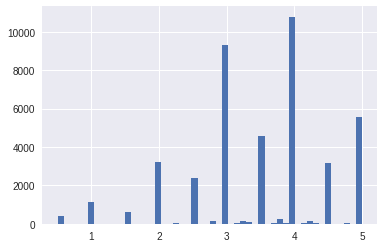

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
ratings['rating'].hist(bins=50)


In [0]:
df.head(5)

,id,title,userId,movieId,rating,timestamp
0,862,Toy Story,1,110,1.0,1425941529
1,8844,Jumanji,1,147,4.5,1425942435
2,15602,Grumpier Old Men,1,858,5.0,1425941523
3,31357,Waiting to Exhale,1,1221,5.0,1425941546
4,11862,Father of the Bride Part II,1,1246,5.0,1425941556


In [0]:
movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')
movie_matrix.head()


title,!Women Art Revolution,#1 Cheerleader Camp,#Horror,#chicagoGirl,"$1,000 on the Black","$100,000 for Ringo",$5 a Day,$50K and a Call Girl: A Love Story,$9.99,$ellebrity,...,Путь к себе,Семь кабинок,Совершенно серьезно,Убить дракона,Юленька,هیچ کجا هیچ کس,‘Rameau’s Nephew’ by Diderot (Thanx to Dennis Young) by Wilma Schoen,’Round Midnight,…And the Fifth Horseman Is Fear,ファンタスティポ
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
ratings.sort_values('number_of_ratings', ascending=False).head(10)

,rating,number_of_ratings
title,,
Cinderella,4.136364,11
Alice in Wonderland,2.722222,9
Hamlet,3.500000,9
Les Misérables,2.937500,8
Beauty and the Beast,3.875000,8
The Three Musketeers,3.285714,7
Treasure Island,3.357143,7
Blackout,3.285714,7
A Christmas Carol,3.642857,7
